<a href="https://colab.research.google.com/github/anishkodadala/Projects-Resume-/blob/main/Resnet50_pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive  # Google Drive integration

# Mount Google Drive to access files
drive.mount('/content/drive')

# Load the ResNet50 model pre-trained on ImageNet without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Build the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [4]:
# Prepare data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set up directories for training and testing data
train_dir = '/content/drive/MyDrive/archive (3)/chest_xray/train'  # Replace with your correct path
test_dir = '/content/drive/MyDrive/archive (3)/chest_xray/test'    # Replace with your correct path

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5232 images belonging to 2 classes.
Found 623 images belonging to 3 classes.


In [5]:
# Model Checkpoint to save the best model
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/archive (3)/chest_xray/pneumonia_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 1449s 9s/step - accuracy: 0.6953 - loss: 0.6841 - val_accuracy: 0.3059 - val_loss: -0.4196
Epoch 2/5
  1/163 ━━━━━━━━━━━━━━━━━━━━ 14:30 5s/step - accuracy: 0.7188 - loss: 0.4659

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7188 - loss: 0.4659 - val_accuracy: 0.4667 - val_loss: -0.6204
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1287s 8s/step - accuracy: 0.7788 - loss: 0.4564 - val_accuracy: 0.3125 - val_loss: -1.0996
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7500 - loss: 0.5529 - val_accuracy: 0.4000 - val_loss: -1.0387
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1376s 8s/step - accuracy: 0.7902 - loss: 0.4245 - val_accuracy: 0.3405 - val_loss: -1.5727
20/20 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step - accuracy: 0.3485 - loss: -1.5163
Test Accuracy: 33.55%


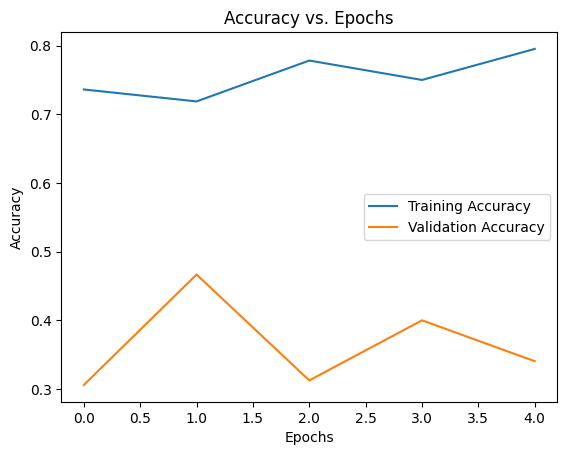

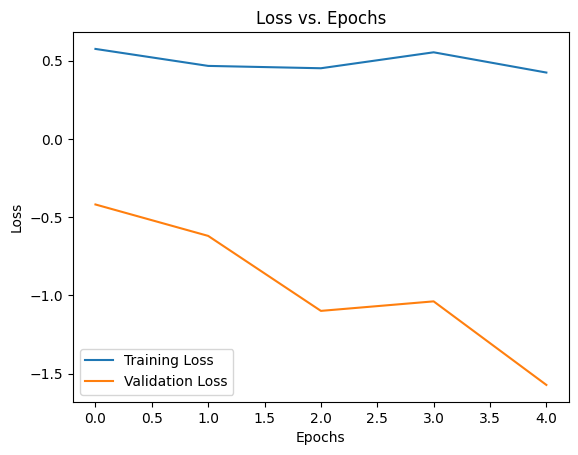

In [6]:
# Save the trained model explicitly in .h5 format
model.save('/content/drive/MyDrive/archive (3)/chest_xray/pneumonia_detection_model.h5')

# Add performance metrics visualization
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


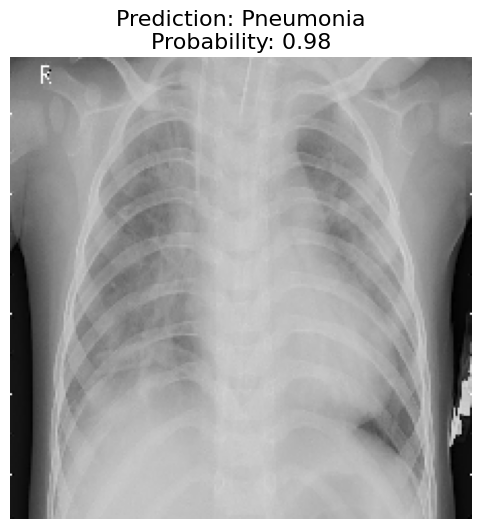

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define a function to predict and visualize a single image
def predict_and_visualize(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array_expanded)
    label = 'Pneumonia' if prediction[0][0] > 0.5 else 'Normal'
    probability = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    img_np = np.array(img)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np.astype('uint8'))
    plt.axis('off')
    plt.title(f"Prediction: {label}\nProbability: {probability:.2f}", fontsize=16)
    plt.show()

# Provide the path to the image
image_path = '/content/drive/MyDrive/archive (3)/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0001.jpeg'
predict_and_visualize(image_path, model)
